# Generating Fractals for end-to-end mask optimization

In [1]:
import imageio
import matplotlib
import matplotlib.pyplot as plt

from utils.core import train, generate
from utils.core import show_masks, show_pattern
from utils.core import target_regular, target_diag, target_image

%matplotlib widget

# Regular Mask
## Mask training
First, the generating pattern is learned using the target mask.
Here, you can choose:
  - the size of the base pattern, which is `m` x `m`.
  - the number of spectral channels, `k`
  - The `depth` to the generating fractal. The reslting size is grows exponentially in the depth, so do not increase it too much.
  
The pattern is trained for `n_iter` interations using an entropy regularization strength of `lambda_e`.

Note that, here, the training is done on the CPU, so it is much slower than in practice using a GPU.

In [2]:
m = 2
k = 4
depth = 3
target = target_regular
pattern_regular = train(m, k, depth, target=target, n_iter=2500,  lambda_e=1e-3)

  0%|          | 0/2500 [00:00<?, ?it/s]

## Mask generation
Generate the mask using the learned pattern.

Here, two patterns are generated, one using a soft forward pass (`binarize=False`), and one using the hard forward pass (`binarize=True`).

You can also adapt the depth to create larger fractals using the learned pattern.

In [3]:
fractal_continuous = generate(m, k, depth, pattern_regular, binarize=False, symmetrize=False)
fractal_binary = generate(m, k, depth, pattern_regular, binarize=True, symmetrize=False)
print("Fractal shape: ", fractal_continuous.shape)
print("Pattern shape: ", pattern_regular.shape)

Fractal shape:  torch.Size([8, 8, 4])
Pattern shape:  torch.Size([2, 2, 4, 4])


## Mask visualization
Now, we can visualize the mask and patterns.
The horizontal "axis", i.e. the different images aranged horizontally, correspond to the different spectral channels.
That is, each channel is plotted individually.

Top: Target mask

Middle: Generated mask (soft forward and hard forward)

Bottom: Generating pattern

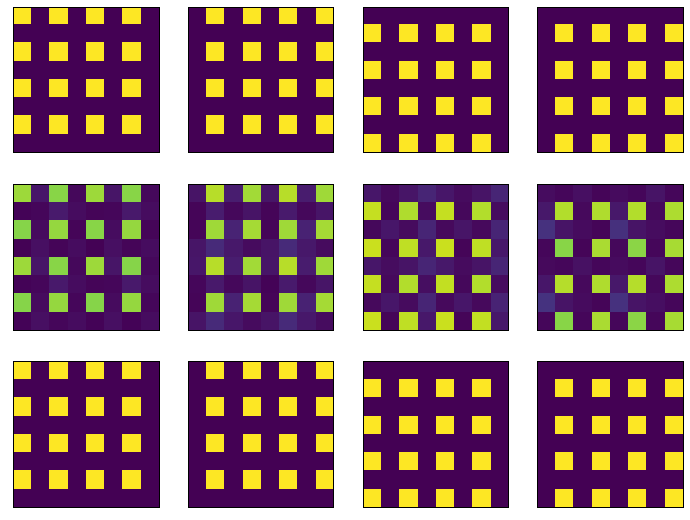

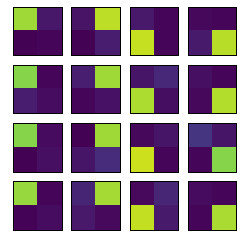

In [4]:
show_masks([target(m, k, depth), fractal_continuous, fractal_binary])
show_pattern(pattern_regular)

## Results
So the generated fractals approximates the target well. 
In the binary version, the patterns agree.

This is not too suprising, as the target itself is a fractal. 
However, it is nice to observe that the optimization via backprop and gradient descent works well, despite the recurrent generation of the fractal and the possibly chaotic behavior.

# Complex regular mask
Next, consider a more complex but still regular target.
Here, let's generate the final fractal also with a higher depth to visualize the fractal generation process.

In [5]:
m = 5
k = 4
depth = 2
target = target_regular
pat_reg_2 = train(m, k, depth, target=target, n_iter=4000)

  0%|          | 0/4000 [00:00<?, ?it/s]

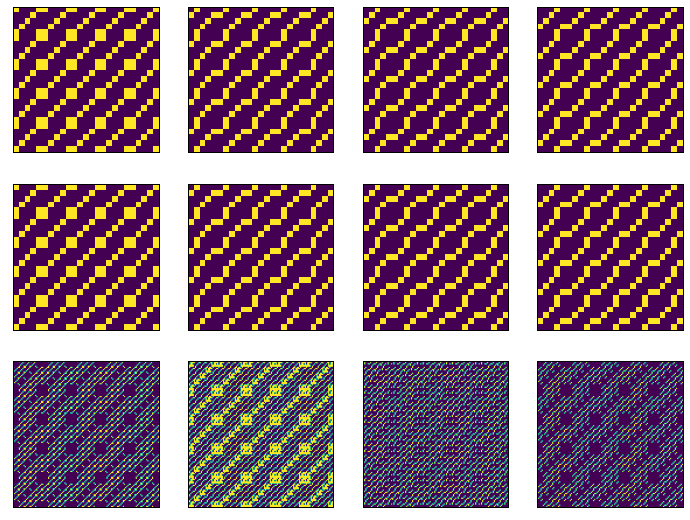

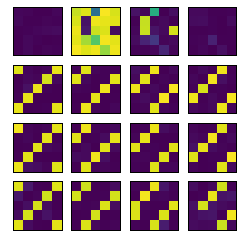

In [6]:
fraktal = generate(m, k, depth, pat_reg_2, binarize=True, symmetrize=False)
fraktal_high = generate(m, k, depth+1, pat_reg_2, binarize=True, symmetrize=False)
show_masks([target(m, k, depth), fraktal, fraktal_high])
show_pattern(pat_reg_2)

# Diagonal Mask
Now, let's consider a non-regular, non-binary diagonal mask. 

This case is tricky, since the target mask is neither regular, nor is it binary.
Let's see what the genaration approximates.
Since the task is more complex, we need more itarations here.

  0%|          | 0/5001 [00:00<?, ?it/s]

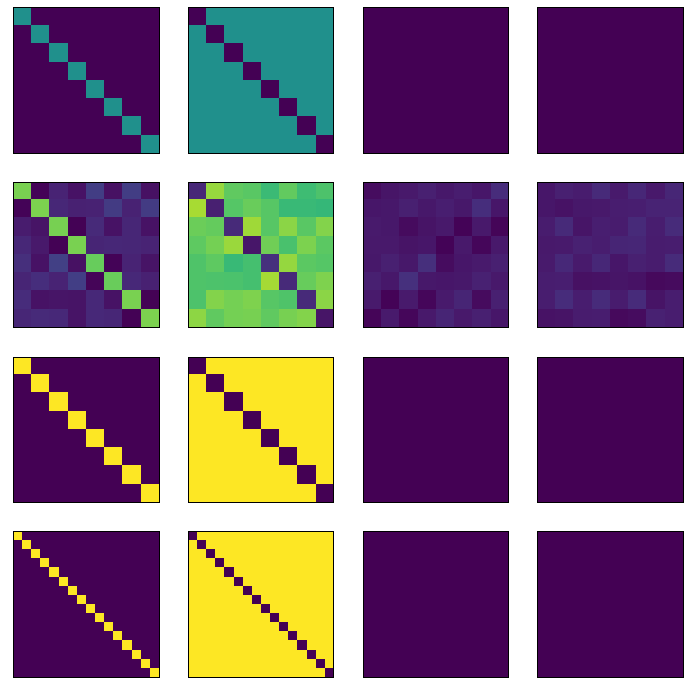

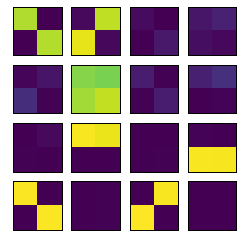

In [7]:
m = 2
k = 4
depth = 3
target = target_diag
pat_diag = train(m, k, depth, target=target, lambda_e=1e-3, n_iter=5001)
fraktal_c = generate(m, k, depth, pat_diag, binarize=False)
fraktal = generate(m, k, depth, pat_diag, binarize=True)
fraktal_high_depth = generate(m, k, depth+1, pat_diag, binarize=True)
show_masks([target(m, k, depth), fraktal_c, fraktal, fraktal_high_depth])
show_pattern(pat_diag)

## Results
While it is more difficult for the fractal to approximate this target mask (as seen in the continuous pattern), the binarized version well approximates the shape of the diagional target -- even at higher depth!

Note that sometimes the training is not succesful. If so, try rerunning it.

# Fitting an Image
As another toy example, we can learn a fractal to approximate an image at a certain depth.
Then, the fractal can be generated at a higher depth to create a fractal version of the image.

To this end, the target mask corresponds to the original (greyscale) and the inverted image.
This way, bright and dark "macropixels" can be learned in a fractal fashion.

In [8]:
im = imageio.imread("./img/portrait_256.png")

In [9]:
m = 16
k = 2
depth = 2
target = lambda i,j,_: target_image(im, dims=k)
pat_im = train(m, k, depth, target=target, n_iter=10_000, lambda_e=0, lambda_s=0, lr=1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

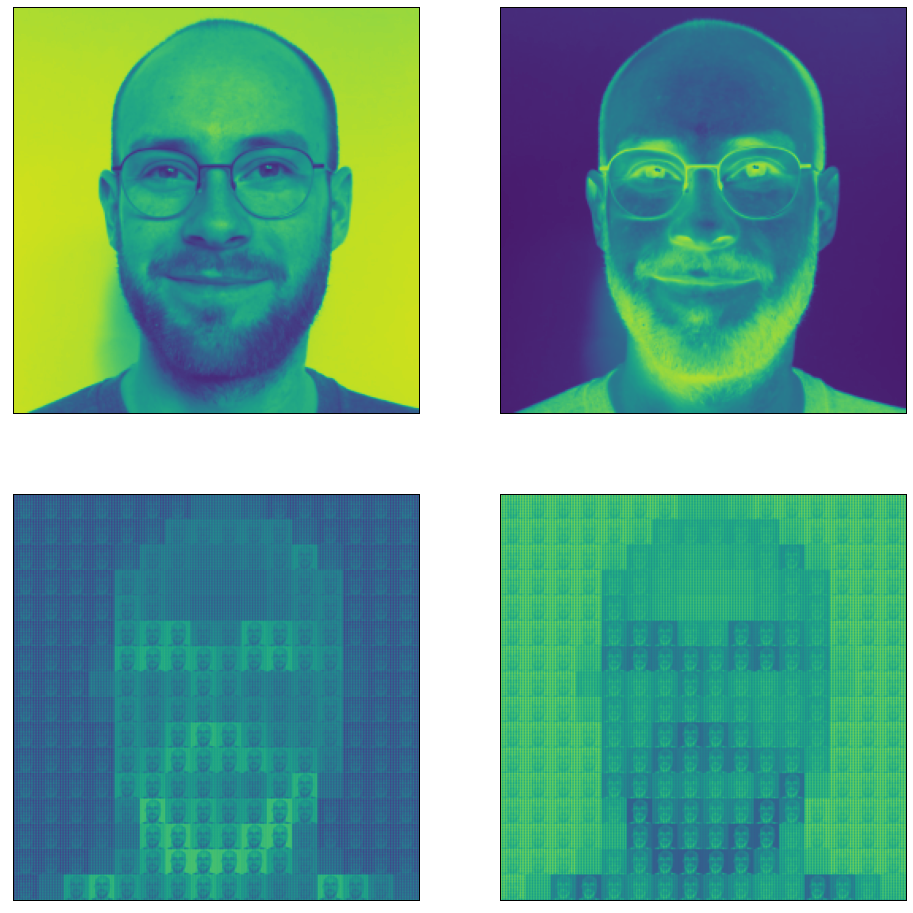

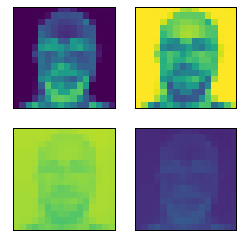

In [10]:
fraktal_im = generate(m, k, depth+1, pat_im, binarize=False)
show_masks([target(0,0,0), fraktal_im], figsize_base=8)
show_pattern(pat_im)

# Fiting a Font

As final toy example, we can also generate fractal fonts, following the same approach.

To this end, each character is individually approximated by a fractal at one depth higher than the training.

In [11]:
from utils.core import generate_word

In [12]:
word = "IIIT⊗KIT"
im_iiit, trgt_iiit = generate_word(word, show=False, iterations=5000)

Generating character 1 of 8

Generating character 2 of 881021118

Generating character 3 of 886239243

Generating character 4 of 819478989

Generating character 5 of 808624268

Generating character 6 of 898826599

Generating character 7 of 878984074

Generating character 8 of 899954987



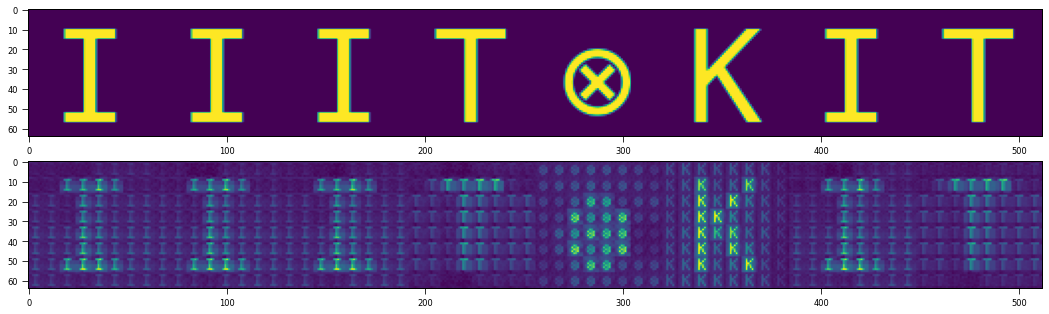

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(len(word)*5, 5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.imshow(trgt_iiit[...,0])
ax2.imshow(im_iiit)
plt.show()